<a href="https://colab.research.google.com/github/Weaamzd/SPAI-Project/blob/main/AI_LayerModel_SPAIPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing and importing dependenciesa

In [ ]:
!pip install ultralytics

In [ ]:
!pip install supervision

In [ ]:
import cv2
import os
import pickle
import sys
from ultralytics import YOLO
import supervision as sv
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils Functions

In [ ]:
# ========================
# Utils Functions
# ========================


def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    return frames

def save_video(ouput_video_frames,output_video_path):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, 24, (ouput_video_frames[0].shape[1], ouput_video_frames[0].shape[0]))
    for frame in ouput_video_frames:
        out.write(frame)
    out.release()

def get_center_of_bbox(bbox):
    x1, y1, x2, y2 = bbox
    return int((x1 + x2) / 2), int((y1 + y2) / 2)

def get_bbox_width(bbox):
    return bbox[2] - bbox[0]

def measure_distance(p1,p2):
  return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

def measure_xy_distance(p1,p2):
    return p1[0]-p2[0],p1[1]-p2[1]

def get_foot_position(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2),int(y2)

## Tracker Class

In [ ]:
# ========================
# Tracker Class
# ========================

class Tracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.tracker = sv.ByteTrack()

    def add_position_to_tracks(sekf,tracks):
        for object, object_tracks in tracks.items():
            for frame_num, track in enumerate(object_tracks):
                for track_id, track_info in track.items():
                    bbox = track_info['bbox']
                    if object == 'ball':
                        position= get_center_of_bbox(bbox)
                    else:
                        position = get_foot_position(bbox)
                    tracks[object][frame_num][track_id]['position'] = position

    def interpolate_ball_positions(self,ball_positions):
        ball_positions = [x.get(1,{}).get('bbox',[]) for x in ball_positions]
        df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

        # Interpolate missing values
        df_ball_positions = df_ball_positions.interpolate()
        df_ball_positions = df_ball_positions.bfill()

        ball_positions = [{1: {"bbox":x}} for x in df_ball_positions.to_numpy().tolist()]

        return ball_positions


    def detect_frames(self, frames):
        batch_size=8
        detections = []
        for i in range(0,len(frames),batch_size):
            detections_batch = self.model.predict(frames[i:i+batch_size],conf=0.1)
            detections += detections_batch
        return detections

    def get_object_tracks(self, frames):



        detections = self.detect_frames(frames)

        tracks={
            "players":[],
            "referees":[],
            "ball":[]
        }

        for frame_num, detection in enumerate(detections):
            cls_names = detection.names
            cls_names_inv = {v:k for k,v in cls_names.items()}

            # Covert to supervision Detection format
            detection_supervision = sv.Detections.from_ultralytics(detection)

            # Convert GoalKeeper to player object
            for object_ind , class_id in enumerate(detection_supervision.class_id):
                if cls_names[class_id] == "goalkeeper":
                    detection_supervision.class_id[object_ind] = cls_names_inv["player"]

            # Track Objects
            detection_with_tracks = self.tracker.update_with_detections(detection_supervision)

            tracks["players"].append({})
            tracks["referees"].append({})
            tracks["ball"].append({})

            for frame_detection in detection_with_tracks:
                bbox = frame_detection[0].tolist()
                cls_id = frame_detection[3]
                track_id = frame_detection[4]

                if cls_id == cls_names_inv['player']:
                    tracks["players"][frame_num][track_id] = {"bbox":bbox}

                if cls_id == cls_names_inv['referee']:
                    tracks["referees"][frame_num][track_id] = {"bbox":bbox}

            for frame_detection in detection_supervision:
                bbox = frame_detection[0].tolist()
                cls_id = frame_detection[3]

                if cls_id == cls_names_inv['ball']:
                    tracks["ball"][frame_num][1] = {"bbox":bbox}



        return tracks

    def draw_ellipse(self,frame,bbox,color,track_id=None):
        y2 = int(bbox[3])
        x_center, _ = get_center_of_bbox(bbox)
        width = get_bbox_width(bbox)

        cv2.ellipse(
            frame,
            center=(x_center,y2),
            axes=(int(width), int(0.35*width)),
            angle=0.0,
            startAngle=-45,
            endAngle=235,
            color = color,
            thickness=2,
            lineType=cv2.LINE_4
        )

        rectangle_width = 40
        rectangle_height=20
        x1_rect = x_center - rectangle_width//2
        x2_rect = x_center + rectangle_width//2
        y1_rect = (y2- rectangle_height//2) +15
        y2_rect = (y2+ rectangle_height//2) +15

        if track_id is not None:
            cv2.rectangle(frame,
                          (int(x1_rect),int(y1_rect) ),
                          (int(x2_rect),int(y2_rect)),
                          color,
                          cv2.FILLED)

            x1_text = x1_rect+12
            if track_id > 99:
                x1_text -=10

            cv2.putText(
                frame,
                f"{track_id}",
                (int(x1_text),int(y1_rect+15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0,0,0),
                2
            )

        return frame

    def draw_triangle(self, frame, bbox, color):
      y= int(bbox[1])
      x,_= get_center_of_bbox(bbox)

      triangle_points= np.array([
          [x,y],
          [x-10,y-20],
          [x+10,y-20],
      ])

      cv2.drawContours(frame, [triangle_points], 0, color, cv2.FILLED)
      cv2.drawContours(frame, [triangle_points], 0, (0,0,0), 2)

      return frame

    def draw_team_ball_control(self,frame,frame_num,team_ball_control):
        # Draw a semi-transparent rectaggle
        overlay = frame.copy()
        cv2.rectangle(overlay, (1350, 850), (1900,970), (255,255,255), -1 )
        alpha = 0.4
        cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

        team_ball_control_till_frame = team_ball_control[:frame_num+1]
        # Get the number of time each team had ball control
        team_1_num_frames = team_ball_control_till_frame[team_ball_control_till_frame==1].shape[0]
        team_2_num_frames = team_ball_control_till_frame[team_ball_control_till_frame==2].shape[0]
        team_1 = team_1_num_frames/(team_1_num_frames+team_2_num_frames)
        team_2 = team_2_num_frames/(team_1_num_frames+team_2_num_frames)

        cv2.putText(frame, f"Team 1 Ball Control: {team_1*100:.2f}%",(1400,900), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 3)
        cv2.putText(frame, f"Team 2 Ball Control: {team_2*100:.2f}%",(1400,950), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 3)

        return frame




    def draw_annotations(self,video_frames, tracks, team_ball_control):
        output_video_frames= []
        for frame_num, frame in enumerate(video_frames):
            frame = frame.copy()

            player_dict = tracks["players"][frame_num]
            ball_dict = tracks["ball"][frame_num]
            referee_dict = tracks["referees"][frame_num]

            # Draw Players
            for track_id, player in player_dict.items():
                color = player.get("team_color", (0,0,255))
                frame = self.draw_ellipse(frame, player["bbox"],color, track_id)

                if player.get('has_ball', False):
                  frame = self.draw_triangle(frame, player["bbox"], (0,0,255))

            # Draw Referees
            for _, referee in referee_dict.items():
                frame = self.draw_ellipse(frame, referee["bbox"],(0,255,255))

            #Draw ball
            for track_id, ball in ball_dict.items():
              frame = self.draw_triangle(frame, ball["bbox"], (0,255,0))

            #Draw Team Ball Control
            frame = self.draw_team_ball_control(frame,frame_num, team_ball_control)




            output_video_frames.append(frame)

        return output_video_frames

## Team Assigner Class

In [ ]:
# ========================
# Team Assigner Class
# ========================

from sklearn.cluster import KMeans

class TeamAssigner:
  def __init__(self):
    self.team_colors = {}
    self.player_team_dict = {}

  def get_clustering_model(self, image):
     # Reshape the image to 2D array

     image = image[:, :, :3]  # Remove the extra channel
     image_2d = image.reshape(-1,3)

     # Preform K-means with 2 clusters
     kmeans = KMeans(n_clusters=2, init="k-means++", n_init=1)
     kmeans.fit(image_2d)

     return kmeans

  def get_player_color(self, frame, bbox):
    image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

    top_half_image = image[0:int(image.shape[0]/2), :]

    # Get Clustering model
    kmeans = self.get_clustering_model(top_half_image)

    # Get the cluster labels forr each pixel
    labels = kmeans.labels_

    # Reshape the labels to the image shape
    clustered_image = labels.reshape(top_half_image.shape[0],top_half_image.shape[1])

    # Get the player cluster
    corner_clusters = [clustered_image[0,0],clustered_image[0,-1],clustered_image[-1,0],clustered_image[-1,-1]]
    non_player_cluster = max(set(corner_clusters),key=corner_clusters.count)
    player_cluster = 1 - non_player_cluster

    player_color = kmeans.cluster_centers_[player_cluster]

    return player_color




  def assign_team_color(self, frame, player_detections):
    player_colors = []

    for _, player_detection in player_detections.items():
      bbox = player_detection['bbox']
      player_color = self.get_player_color(frame,bbox)
      player_colors.append(player_color)

    kmeans = KMeans(n_clusters=2, init="k-means++", n_init=1)
    kmeans.fit(player_colors)

    self.kmeans = kmeans

    self.team_colors[1] = kmeans.cluster_centers_[0]
    self.team_colors[2] = kmeans.cluster_centers_[1]

  def get_player_team(self,frame,player_bbox,player_id):
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]

        player_color = self.get_player_color(frame,player_bbox)

        team_id = self.kmeans.predict(player_color.reshape(1,-1))[0]
        team_id+=1

        if player_id ==91:
            team_id=1

        self.player_team_dict[player_id] = team_id

        return team_id


## Player Ball Assigner Class

In [ ]:
# =============================
# Player Ball Assigner Class
# =============================

class PlayerBallAssigner():
    def __init__(self):
        self.max_player_ball_distance = 70

    def assign_ball_to_player(self,players,ball_bbox):
        ball_position = get_center_of_bbox(ball_bbox)

        miniumum_distance = 99999
        assigned_player=-1

        for player_id, player in players.items():
            player_bbox = player['bbox']

            distance_left = measure_distance((player_bbox[0],player_bbox[-1]),ball_position)
            distance_right = measure_distance((player_bbox[2],player_bbox[-1]),ball_position)
            distance = min(distance_left,distance_right)

            if distance < self.max_player_ball_distance:
                if distance < miniumum_distance:
                    miniumum_distance = distance
                    assigned_player = player_id

        return assigned_player

## Camera Movement Estimator Class

In [ ]:
# ================================
# Camera Movement Estimator Class
# ================================

class CameraMovementEstimator():
  def __init__(self,frame):
        self.minimum_distance = 5

        self.lk_params = dict(
            winSize = (15,15),
            maxLevel = 2,
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03)
        )

        first_frame_grayscale = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        mask_features = np.zeros_like(first_frame_grayscale)
        mask_features[:,0:20] = 1
        mask_features[:,900:1050] = 1

        self.features = dict(
            maxCorners = 100,
            qualityLevel = 0.3,
            minDistance =3,
            blockSize = 7,
            mask = mask_features
        )

  def add_adjust_positions_to_tracks(self,tracks, camera_movement_per_frame):
        for object, object_tracks in tracks.items():
            for frame_num, track in enumerate(object_tracks):
                for track_id, track_info in track.items():
                    position = track_info['position']
                    camera_movement = camera_movement_per_frame[frame_num]
                    position_adjusted = (position[0]-camera_movement[0],position[1]-camera_movement[1])
                    tracks[object][frame_num][track_id]['position_adjusted'] = position_adjusted



  def get_camera_movement(self,frames,read_from_stub=False, stub_path=None):
        # Read the stub
        if read_from_stub and stub_path is not None and os.path.exists(stub_path):
            with open(stub_path,'rb') as f:
                return pickle.load(f)

        camera_movement = [[0,0]]*len(frames)

        old_gray = cv2.cvtColor(frames[0],cv2.COLOR_BGR2GRAY)
        old_features = cv2.goodFeaturesToTrack(old_gray,**self.features)

        for frame_num in range(1,len(frames)):
            frame_gray = cv2.cvtColor(frames[frame_num],cv2.COLOR_BGR2GRAY)
            new_features, _,_ = cv2.calcOpticalFlowPyrLK(old_gray,frame_gray,old_features,None,**self.lk_params)

            max_distance = 0
            camera_movement_x, camera_movement_y = 0,0

            for i, (new,old) in enumerate(zip(new_features,old_features)):
                new_features_point = new.ravel()
                old_features_point = old.ravel()

                distance = measure_distance(new_features_point,old_features_point)
                if distance>max_distance:
                    max_distance = distance
                    camera_movement_x,camera_movement_y = measure_xy_distance(old_features_point, new_features_point )

            if max_distance > self.minimum_distance:
                camera_movement[frame_num] = [camera_movement_x,camera_movement_y]
                old_features = cv2.goodFeaturesToTrack(frame_gray,**self.features)

            old_gray = frame_gray.copy()

        if stub_path is not None:
            with open(stub_path,'wb') as f:
                pickle.dump(camera_movement,f)

        return camera_movement

  def draw_camera_movement(self,frames, camera_movement_per_frame):
        output_frames=[]

        for frame_num, frame in enumerate(frames):
            frame= frame.copy()

            overlay = frame.copy()
            cv2.rectangle(overlay,(0,0),(500,100),(255,255,255),-1)
            alpha =0.6
            cv2.addWeighted(overlay,alpha,frame,1-alpha,0,frame)

            x_movement, y_movement = camera_movement_per_frame[frame_num]
            frame = cv2.putText(frame,f"Camera Movement X: {x_movement:.2f}",(10,30), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),3)
            frame = cv2.putText(frame,f"Camera Movement Y: {y_movement:.2f}",(10,60), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),3)

            output_frames.append(frame)

        return output_frames

## View Transformer Class

In [ ]:
# ========================
# View Transformer Class
# ========================

class ViewTransformer():
    def __init__(self):
        court_width = 68
        court_length = 23.32

        self.pixel_vertices = np.array([[110, 1035],
                               [265, 275],
                               [910, 260],
                               [1640, 915]])

        self.target_vertices = np.array([
            [0,court_width],
            [0, 0],
            [court_length, 0],
            [court_length, court_width]
        ])

        self.pixel_vertices = self.pixel_vertices.astype(np.float32)
        self.target_vertices = self.target_vertices.astype(np.float32)

        self.persepctive_trasnformer = cv2.getPerspectiveTransform(self.pixel_vertices, self.target_vertices)

    def transform_point(self,point):
        p = (int(point[0]),int(point[1]))
        is_inside = cv2.pointPolygonTest(self.pixel_vertices,p,False) >= 0
        if not is_inside:
            return None

        reshaped_point = point.reshape(-1,1,2).astype(np.float32)
        tranform_point = cv2.perspectiveTransform(reshaped_point,self.persepctive_trasnformer)
        return tranform_point.reshape(-1,2)

    def add_transformed_position_to_tracks(self,tracks):
        for object, object_tracks in tracks.items():
            for frame_num, track in enumerate(object_tracks):
                for track_id, track_info in track.items():
                    position = track_info['position_adjusted']
                    position = np.array(position)
                    position_trasnformed = self.transform_point(position)
                    if position_trasnformed is not None:
                        position_trasnformed = position_trasnformed.squeeze().tolist()
                    tracks[object][frame_num][track_id]['position_transformed'] = position_trasnformed

## Speed And Distance Estimator Class

In [ ]:
# ===================================
# Speed And Distance Estimator Class
# ===================================

class SpeedAndDistance_Estimator():
    def __init__(self):
        self.frame_window=5
        self.frame_rate=24

    def add_speed_and_distance_to_tracks(self,tracks):
        total_distance= {}

        for object, object_tracks in tracks.items():
            if object == "ball" or object == "referees":
                continue
            number_of_frames = len(object_tracks)
            for frame_num in range(0,number_of_frames, self.frame_window):
                last_frame = min(frame_num+self.frame_window,number_of_frames-1 )

                for track_id,_ in object_tracks[frame_num].items():
                    if track_id not in object_tracks[last_frame]:
                        continue

                    start_position = object_tracks[frame_num][track_id]['position_transformed']
                    end_position = object_tracks[last_frame][track_id]['position_transformed']

                    if start_position is None or end_position is None:
                        continue

                    distance_covered = measure_distance(start_position,end_position)
                    time_elapsed = (last_frame-frame_num)/self.frame_rate
                    speed_meteres_per_second = distance_covered/time_elapsed
                    speed_km_per_hour = speed_meteres_per_second*3.6

                    if object not in total_distance:
                        total_distance[object]= {}

                    if track_id not in total_distance[object]:
                        total_distance[object][track_id] = 0

                    total_distance[object][track_id] += distance_covered

                    for frame_num_batch in range(frame_num,last_frame):
                        if track_id not in tracks[object][frame_num_batch]:
                            continue
                        tracks[object][frame_num_batch][track_id]['speed'] = speed_km_per_hour
                        tracks[object][frame_num_batch][track_id]['distance'] = total_distance[object][track_id]

    def draw_speed_and_distance(self,frames,tracks):
        output_frames = []
        for frame_num, frame in enumerate(frames):
            for object, object_tracks in tracks.items():
                if object == "ball" or object == "referees":
                    continue
                for _, track_info in object_tracks[frame_num].items():
                   if "speed" in track_info:
                       speed = track_info.get('speed',None)
                       distance = track_info.get('distance',None)
                       if speed is None or distance is None:
                           continue

                       bbox = track_info['bbox']
                       position = get_foot_position(bbox)
                       position = list(position)
                       position[1]+=40

                       position = tuple(map(int,position))
                       cv2.putText(frame, f"{speed:.2f} km/h",position,cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
                       cv2.putText(frame, f"{distance:.2f} m",(position[0],position[1]+20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
            output_frames.append(frame)

        return output_frames

## Draw

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib.patches import Circle


class SoccerSimulation:
    def __init__(self, video_frames, tracks, output_size=(800, 500)):
        self.tracks = tracks
        self.output_size = output_size
        self.fig = plt.figure(figsize=(16, 9))

        # Get video dimensions for proper scaling
        self.video_height, self.video_width = video_frames[0].shape[:2]

        # Create subplots
        self.ax1 = self.fig.add_subplot(2, 1, 1)  # Original video
        self.ax2 = self.fig.add_subplot(2, 1, 2)  # Simulation

        # Initialize elements
        self.field_img = self.create_field()
        self.setup_colors()
        self.initialize_tracking_elements()

        # Store video frames
        self.video_frames = video_frames

    def setup_colors(self):
        """Configure team colors in proper 0-1 range"""
        self.team1_color = (0, 0, 1)  # Blue
        self.team2_color = (1, 0, 0)  # Red
        self.referee_color = (1, 1, 0)  # Yellow
        self.ball_color = (1, 1, 1)    # White

    def initialize_tracking_elements(self):
        """Initialize tracking elements"""
        self.players_team1 = []
        self.players_team2 = []
        self.referees = []
        self.ball = None



    def create_field(self):

     field = np.zeros((self.output_size[1], self.output_size[0], 3), dtype=np.float32)

    # لون الملعب الأخضر
     field[:, :, 1] = 0.55  # درجة أخضر أكثر واقعية

    # الحدود الخارجية للملعب
     border_thickness = 3
     cv2.rectangle(field, (50, 50), (self.output_size[0] - 50, self.output_size[1] - 50), (1, 1, 1), border_thickness)

    # خط المنتصف
     cv2.line(field, (self.output_size[0] // 2, 50), (self.output_size[0] // 2, self.output_size[1] - 50), (1, 1, 1), 2)

    # دائرة المنتصف
     cv2.circle(field, (self.output_size[0] // 2, self.output_size[1] // 2), 70, (1, 1, 1), 2)
     cv2.circle(field, (self.output_size[0] // 2, self.output_size[1] // 2), 5, (1, 1, 1), -1)  # نقطة المنتصف

    # منطقة الجزاء
     penalty_area_width = 200
     penalty_area_height = 100
     six_yard_box_height = 50

    # مناطق الجزاء
     cv2.rectangle(field, (50, self.output_size[1] // 2 - penalty_area_height // 2),
                  (50 + penalty_area_width, self.output_size[1] // 2 + penalty_area_height // 2), (1, 1, 1), 2)
     cv2.rectangle(field, (self.output_size[0] - 50 - penalty_area_width, self.output_size[1] // 2 - penalty_area_height // 2),
                  (self.output_size[0] - 50, self.output_size[1] // 2 + penalty_area_height // 2), (1, 1, 1), 2)

    # مناطق الست ياردات
     cv2.rectangle(field, (50, self.output_size[1] // 2 - six_yard_box_height // 2),
                  (50 + penalty_area_width // 2, self.output_size[1] // 2 + six_yard_box_height // 2), (1, 1, 1), 2)
     cv2.rectangle(field, (self.output_size[0] - 50 - penalty_area_width // 2, self.output_size[1] // 2 - six_yard_box_height // 2),
                  (self.output_size[0] - 50, self.output_size[1] // 2 + six_yard_box_height // 2), (1, 1, 1), 2)

    # نقطة الجزاء
     penalty_spot_offset = 70
     cv2.circle(field, (50 + penalty_spot_offset, self.output_size[1] // 2), 5, (1, 1, 1), -1)
     cv2.circle(field, (self.output_size[0] - 50 - penalty_spot_offset, self.output_size[1] // 2), 5, (1, 1, 1), -1)

    # المرمى
     goal_width = 100
     goal_depth = 40
     cv2.rectangle(field, (50 - goal_depth, self.output_size[1] // 2 - goal_width // 2),
                  (50, self.output_size[1] // 2 + goal_width // 2), (1, 1, 1), 2)
     cv2.rectangle(field, (self.output_size[0] - 50, self.output_size[1] // 2 - goal_width // 2),
                  (self.output_size[0] - 50 + goal_depth, self.output_size[1] // 2 + goal_width // 2), (1, 1, 1), 2)

    # زوايا الركنيات
     corner_radius = 10
     cv2.ellipse(field, (50, 50), (corner_radius, corner_radius), 0, 0, 90, (1, 1, 1), 2)
     cv2.ellipse(field, (self.output_size[0] - 50, 50), (corner_radius, corner_radius), 0, 90, 180, (1, 1, 1), 2)
     cv2.ellipse(field, (50, self.output_size[1] - 50), (corner_radius, corner_radius), 0, 270, 360, (1, 1, 1), 2)
     cv2.ellipse(field, (self.output_size[0] - 50, self.output_size[1] - 50), (corner_radius, corner_radius), 0, 180, 270, (1, 1, 1), 2)

     return field




    def scale_position(self, pos):
        """
        Scale position from video coordinates to simulation coordinates
        with proper aspect ratio preservation
        """
        # Calculate scaling factors
        width_scale = (self.output_size[0]-100)/self.video_width
        height_scale = (self.output_size[1]-100)/self.video_height

        # Use the more restrictive scale to maintain aspect ratio
        scale = min(width_scale, height_scale)

        # Calculate margins to center the field
        x_margin = (self.output_size[0] - (self.video_width * scale)) / 2
        y_margin = (self.output_size[1] - (self.video_height * scale)) / 2

        # Scale and translate position
        x = x_margin + pos[0] * scale
        y = y_margin + pos[1] * scale

        return (x, y)

    def init_animation(self):
        """Initialize animation with proper scaling"""
        self.ax1.clear()
        self.ax2.clear()
        self.ax1.axis('off')
        self.ax2.axis('off')

        # Show first video frame
        if self.video_frames:
            self.ax1.imshow(cv2.cvtColor(self.video_frames[0], cv2.COLOR_BGR2RGB))

        # Initialize field and players
        self.ax2.imshow(self.field_img)
        self.initialize_players_and_ball()

        return []

    def initialize_players_and_ball(self):
        """Initialize player and ball positions with proper scaling"""
        frame0_players = self.tracks['players'][0] if self.tracks['players'] else {}
        frame0_ball = self.tracks['ball'][0] if self.tracks['ball'] else {}

        # Initialize players
        for track_id, player in frame0_players.items():
            pos = self.get_position_data(player)
            scaled_pos = self.scale_position(pos)
            self.create_player_marker(track_id, player, scaled_pos)

        # Initialize ball
        if 1 in frame0_ball:
            ball_pos = self.get_position_data(frame0_ball[1])
            scaled_ball_pos = self.scale_position(ball_pos)
            self.ball = Circle(scaled_ball_pos, 5, color=self.ball_color)
            self.ax2.add_patch(self.ball)

    def get_position_data(self, track_info):
        """Helper method to safely get position data from track info"""
        if 'position_transformed' in track_info and track_info['position_transformed'] is not None:
            return track_info['position_transformed']
        elif 'position_adjusted' in track_info:
            return track_info['position_adjusted']
        elif 'position' in track_info:
            return track_info['position']
        elif 'bbox' in track_info:
            # Calculate center position from bbox if position not available
            bbox = track_info['bbox']
            return [(bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2]
        else:
            return [self.video_width//2, self.video_height//2]  # Default center position

    def create_player_marker(self, track_id, player, position):
        """Create a player marker with proper team coloring"""
        if 'team_color' in player:
            color = tuple(c/255.0 for c in player['team_color'][:3]) if max(player['team_color']) > 1 else player['team_color']
        else:
            color = self.team1_color if position[0] < self.output_size[0]//2 else self.team2_color

        player_circle = Circle(position, 8, color=color)
        self.ax2.add_patch(player_circle)

        if color == self.team1_color:
            self.players_team1.append((track_id, player_circle))
        else:
            self.players_team2.append((track_id, player_circle))

    def update_animation(self, frame_num):
        """Update animation with proper position scaling"""
        self.update_video_frame(frame_num)
        self.update_simulation_elements(frame_num)
        return []

    def update_video_frame(self, frame_num):
        """Update the video display"""
        self.ax1.clear()
        self.ax1.axis('off')
        if frame_num < len(self.video_frames):
            self.ax1.imshow(cv2.cvtColor(self.video_frames[frame_num], cv2.COLOR_BGR2RGB))
            self.ax1.set_title(f"Original Video - Frame {frame_num}", fontsize=10)

    def update_simulation_elements(self, frame_num):
        """Update all simulation elements with proper scaling"""
        if frame_num >= len(self.tracks['players']):
            return

        self.update_players(frame_num)
        self.update_ball(frame_num)

    def update_players(self, frame_num):
        """Update player positions with proper scaling"""
        current_players = self.tracks['players'][frame_num]

        for team in [self.players_team1, self.players_team2]:
            for track_id, player_circle in team:
                if track_id in current_players:
                    pos = self.get_position_data(current_players[track_id])
                    player_circle.center = self.scale_position(pos)

    def update_ball(self, frame_num):
        """Update ball position with proper scaling"""
        if frame_num < len(self.tracks['ball']) and self.ball is not None:
            current_ball = self.tracks['ball'][frame_num]
            if 1 in current_ball:
                pos = self.get_position_data(current_ball[1])
                self.ball.center = self.scale_position(pos)

    def generate_simulation(self, output_path="soccer_simulation.mp4"):
        """Generate and save the animation"""
        total_frames = min(len(self.video_frames),
                         len(self.tracks['players']),
                         len(self.tracks['ball']))

        ani = animation.FuncAnimation(
            self.fig,
            self.update_animation,
            frames=total_frames,
            init_func=self.init_animation,
            interval=33,  # ~30 fps
            blit=False
        )

        print(f"Saving animation to {output_path}...")
        writer = animation.FFMpegWriter(fps=30, bitrate=5000)
        ani.save(output_path, writer=writer)
        print("Simulation saved successfully!")
        plt.close()

        return ani

## Draw-2

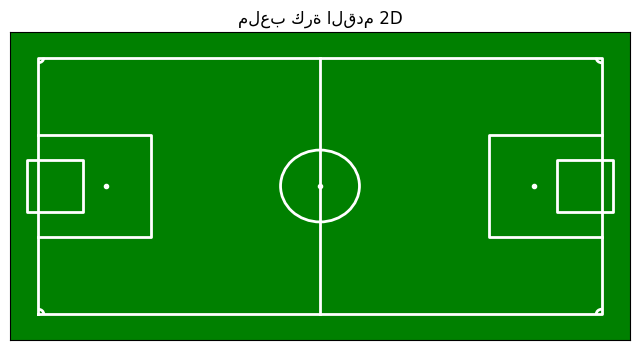

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

def draw_pitch(ax):

    ax.set_facecolor('green')
    field_color = 'white'

    ax.plot([0, 100, 100, 0, 0], [0, 0, 50, 50, 0], color=field_color, linewidth=2)

    ax.plot([50, 50], [0, 50], color=field_color, linewidth=2)

    center_circle = patches.Circle((50, 25), 7, color=field_color, fill=False, linewidth=2)
    ax.add_patch(center_circle)

    ax.plot(50, 25, 'wo', markersize=3)

    ax.plot([100, 80, 80, 100], [15, 15, 35, 35], color=field_color, linewidth=2)

    ax.plot([100, 92, 92, 100], [20, 20, 30, 30], color=field_color, linewidth=2)

    ax.plot(88, 25, 'wo', markersize=3)

    ax.plot([0, 20, 20, 0], [15, 15, 35, 35], color=field_color, linewidth=2)

    ax.plot([0, 8, 8, 0], [20, 20, 30, 30], color=field_color, linewidth=2)

    ax.plot(12, 25, 'wo', markersize=3)


    ax.plot([100, 102, 102, 100], [20, 20, 30, 30], color=field_color, linewidth=2)

    ax.plot([0, -2, -2, 0], [20, 20, 30, 30], color=field_color, linewidth=2)


    corner_radius = 2
    ax.add_patch(patches.Arc((0, 0), corner_radius, corner_radius, angle=0, theta1=0, theta2=90, color=field_color, linewidth=2))
    ax.add_patch(patches.Arc((100, 0), corner_radius, corner_radius, angle=0, theta1=90, theta2=180, color=field_color, linewidth=2))
    ax.add_patch(patches.Arc((100, 50), corner_radius, corner_radius, angle=0, theta1=180, theta2=270, color=field_color, linewidth=2))
    ax.add_patch(patches.Arc((0, 50), corner_radius, corner_radius, angle=0, theta1=270, theta2=360, color=field_color, linewidth=2))


    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 55)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("2D football field")


fig, ax = plt.subplots(figsize=(8, 4))
draw_pitch(ax)
plt.show()


def convert_bbox_to_center(bbox, frame_w, frame_h):
    x1, y1, x2, y2 = bbox
    cx = (x1 + x2) / 2 / frame_w * 100
    cy = (y1 + y2) / 2 / frame_h * 50
    return cx, cy

def generate_simulation_video(tracks, frame_shape, save_path="simulated_field_output.mp4"):
    height, width, _ = frame_shape
    frames = []

    for frame_num in range(len(tracks["players"])):
        fig, ax = plt.subplots(figsize=(8, 4))
        draw_pitch(ax)

        player_points = []
        ball_point = None

        for track_id, player in tracks["players"][frame_num].items():
            cx, cy = convert_bbox_to_center(player["bbox"], width, height)
            player_points.append((cx, cy))

        for track_id, ball in tracks["ball"][frame_num].items():
            cx, cy = convert_bbox_to_center(ball["bbox"], width, height)
            ball_point = (cx, cy)

        if player_points:
            px, py = zip(*player_points)
            ax.plot(px, py, 'ro', label='Players', markersize=5)

        if ball_point:
            ax.plot(ball_point[0], ball_point[1], 'bo', label='Ball', markersize=6)

        ax.legend()


        fig.canvas.draw()
        img = np.array(fig.canvas.renderer.buffer_rgba())

        img = img[:, :, :3]

        img = cv2.resize(img, (width, height))

        frames.append(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.close(fig)

    save_video(frames, save_path)
    print(f"The simulated video was saved in: {save_path}")


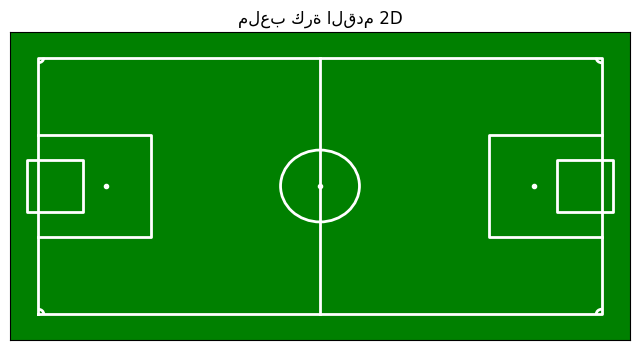

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

def draw_pitch(ax):

    ax.set_facecolor('green')
    field_color = 'white'


    ax.plot([0, 100, 100, 0, 0], [0, 0, 50, 50, 0], color=field_color, linewidth=2)


    ax.plot([50, 50], [0, 50], color=field_color, linewidth=2)

    center_circle = patches.Circle((50, 25), 7, color=field_color, fill=False, linewidth=2)
    ax.add_patch(center_circle)


    ax.plot(50, 25, 'wo', markersize=3)

    ax.plot([100, 80, 80, 100], [15, 15, 35, 35], color=field_color, linewidth=2)

    ax.plot([100, 92, 92, 100], [20, 20, 30, 30], color=field_color, linewidth=2)

    ax.plot(88, 25, 'wo', markersize=3)


    ax.plot([0, 20, 20, 0], [15, 15, 35, 35], color=field_color, linewidth=2)

    ax.plot([0, 8, 8, 0], [20, 20, 30, 30], color=field_color, linewidth=2)

    ax.plot(12, 25, 'wo', markersize=3)


    ax.plot([100, 102, 102, 100], [20, 20, 30, 30], color=field_color, linewidth=2)

    ax.plot([0, -2, -2, 0], [20, 20, 30, 30], color=field_color, linewidth=2)


    corner_radius = 2
    ax.add_patch(patches.Arc((0, 0), corner_radius, corner_radius, angle=0, theta1=0, theta2=90, color=field_color, linewidth=2))
    ax.add_patch(patches.Arc((100, 0), corner_radius, corner_radius, angle=0, theta1=90, theta2=180, color=field_color, linewidth=2))
    ax.add_patch(patches.Arc((100, 50), corner_radius, corner_radius, angle=0, theta1=180, theta2=270, color=field_color, linewidth=2))
    ax.add_patch(patches.Arc((0, 50), corner_radius, corner_radius, angle=0, theta1=270, theta2=360, color=field_color, linewidth=2))


    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 55)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("2D football field")


fig, ax = plt.subplots(figsize=(8, 4))
draw_pitch(ax)
plt.show()


def convert_bbox_to_center(bbox, frame_w, frame_h):
    x1, y1, x2, y2 = bbox
    cx = (x1 + x2) / 2 / frame_w * 100
    cy = (y1 + y2) / 2 / frame_h * 50
    return cx, cy

def generate_simulation_video(tracks, frame_shape, save_path="simulated_field_output.mp4"):
    height, width, _ = frame_shape
    frames = []

    ball_color = 'red'
    referee_color = 'yellow'

    for frame_num in range(len(tracks["players"])):
        fig, ax = plt.subplots(figsize=(8, 4))
        draw_pitch(ax)

        for track_id, player in tracks["players"][frame_num].items():
            bbox = player["bbox"]
            cx, cy = convert_bbox_to_center(bbox, width, height)


            color = player["team_color"] / 255
            ax.plot(cx, cy, marker='o', color=color, markersize=6)

        for track_id, ball in tracks["ball"][frame_num].items():
            cx, cy = convert_bbox_to_center(ball["bbox"], width, height)
            ax.plot(cx, cy, marker='o', color=ball_color, markersize=7)

        for track_id, referee in tracks.get("referee", [{}]*len(tracks["players"]))[frame_num].items():
            cx, cy = convert_bbox_to_center(referee["bbox"], width, height)
            ax.plot(cx, cy, marker='o', color=referee_color, markersize=6)

        fig.canvas.draw()
        img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
        img = cv2.resize(img, (width, height))
        frames.append(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.close(fig)

    save_video(frames, save_path)
    print(f"The simulated video was saved in: {save_path}")



## Mine

In [ ]:
# ========================
# Main Function
# ========================

def main():
    # Read Video
    video_path = '/content/download.mp4'  # Adjust path
    video_frames = read_video(video_path)
    print('Video frames read successfully')

    # Initialize Tracker
    tracker = Tracker('/content/drive/MyDrive/YoloResults_TrainingV2/SPAI_MODELONE_best_V3_16/weights/best.pt')  # Adjust path
    tracks = tracker.get_object_tracks(video_frames)  # Adjust path
    print('Tracker created successfully')

    # Get object positions
    tracker.add_position_to_tracks(tracks)

    # camera movement estimator
    camera_movement_estimator = CameraMovementEstimator(video_frames[0])
    camera_movement_per_frame = camera_movement_estimator.get_camera_movement(video_frames,
                                                                                read_from_stub=True,
                                                                                stub_path='/content/sample_data/camera_movement_stub.pkl')
    camera_movement_estimator.add_adjust_positions_to_tracks(tracks,camera_movement_per_frame)

    # View Trasnformer
    view_transformer = ViewTransformer()
    view_transformer.add_transformed_position_to_tracks(tracks)


    # Interpolate Ball Positions
    tracks['ball'] = tracker.interpolate_ball_positions(tracks['ball'])

    # Speed and distance estimator
    speed_and_distance_estimator = SpeedAndDistance_Estimator()
    speed_and_distance_estimator.add_speed_and_distance_to_tracks(tracks)

    # Assign Player Teams
    team_assigner = TeamAssigner()
    team_assigner.assign_team_color(video_frames[0],
                                    tracks['players'][0])

    for frame_num, player_track in enumerate(tracks['players']):
        for player_id, track in player_track.items():
            team = team_assigner.get_player_team(video_frames[frame_num],
                                                 track['bbox'],
                                                 player_id)
            tracks['players'][frame_num][player_id]['team'] = team
            tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]

    # Assign Ball Aquisition
    player_assigner =PlayerBallAssigner()
    team_ball_control= []
    for frame_num, player_track in enumerate(tracks['players']):
        ball_bbox = tracks['ball'][frame_num][1]['bbox']
        assigned_player = player_assigner.assign_ball_to_player(player_track, ball_bbox)

        if assigned_player != -1:
            tracks['players'][frame_num][assigned_player]['has_ball'] = True
            team_ball_control.append(tracks['players'][frame_num][assigned_player]['team'])
        else:
            team_ball_control.append(team_ball_control[-1])
    team_ball_control= np.array(team_ball_control)



    # Draw output

    ## Draw object Tracks
    output_video_frames = tracker.draw_annotations(video_frames, tracks,team_ball_control)

    ## Draw Camera movement
    output_video_frames = camera_movement_estimator.draw_camera_movement(output_video_frames,camera_movement_per_frame)

    ## Draw Speed and Distance
    speed_and_distance_estimator.draw_speed_and_distance(output_video_frames,tracks)


    # Assuming you have:
      # video_frames - list of video frames
      # tracks - dictionary with tracking data

    #simulation = SoccerSimulation(video_frames, tracks)
    #animation = simulation.generate_simulation("soccer_simulation.mp4")

    ###generate_simulation_video(tracks, video_frames[0].shape, save_path="/content/sample_data/pitch_simulation.mp4")




    # Save Video
    output_video_output_path = '/content/drive/MyDrive/output_1.avi'  # Adjust path
    save_video(output_video_frames, output_video_output_path)
    print('Video saved successfully')



    print('End, The End')

if __name__ == '__main__':
    main()

Video frames read successfully

0: 384x640 1 ball, 22 players, 1 referee, 1 goalkeeper, 3.1ms
1: 384x640 1 ball, 22 players, 1 referee, 1 goalkeeper, 3.1ms
2: 384x640 1 ball, 20 players, 1 referee, 1 goalkeeper, 3.1ms
3: 384x640 1 ball, 20 players, 1 referee, 1 goalkeeper, 3.1ms
4: 384x640 20 players, 1 referee, 1 goalkeeper, 3.1ms
5: 384x640 1 ball, 21 players, 1 referee, 1 goalkeeper, 3.1ms
6: 384x640 20 players, 1 referee, 1 goalkeeper, 3.1ms
7: 384x640 1 ball, 19 players, 1 referee, 1 goalkeeper, 3.1ms
Speed: 2.0ms preprocess, 3.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 20 players, 1 referee, 1 goalkeeper, 3.1ms
1: 384x640 2 balls, 20 players, 1 referee, 1 goalkeeper, 3.1ms
2: 384x640 2 balls, 20 players, 1 referee, 1 goalkeeper, 3.1ms
3: 384x640 1 ball, 20 players, 1 referee, 1 goalkeeper, 3.1ms
4: 384x640 2 balls, 21 players, 1 referee, 1 goalkeeper, 3.1ms
5: 384x640 1 ball, 20 players, 1 referee, 1 goalkeeper, 3.1ms
6: 384x640 20 pl

#**Model**

In [ ]:
# ========================
# Color Assignement
# ========================



import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [ ]:
img_path = '/content/drive/MyDrive/output_videos/cropped_image.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
#take the top half of the image

top_half_image = image[0:int(image.shape[0]/2), :]
plt.imshow(top_half_image)
plt.show()

In [ ]:
print("Top half image shape:", top_half_image.shape)


In [ ]:
top_half_image = top_half_image[:, :, :3]  # Remove the extra channel


In [ ]:
#Cluster the image into two clusters

# Reshape the image into 2d array
image_2d = top_half_image.reshape(-1, 3)

# perform k-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(image_2d)

# get the cluster labels
labels = kmeans.labels_

# reshape the labels into the orginal image shape
clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

# Display the clustered image
plt.imshow(clustered_image)
plt.show()

In [ ]:
#Cluster the image into two clusters

# Reshape the image into 2d array
image_2d = top_half_image.reshape(-1, 3)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=5)  # Adjust eps and min_samples as needed
labels = dbscan.fit_predict(image_2d)

# get the cluster labels
labels = dbscan.labels_

# reshape the labels into the orginal image shape
clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

# Display the clustered image
plt.imshow(clustered_image)  # Use a colormap to show clusters
plt.colorbar()
plt.show()

In [ ]:
# Identify the most common cluster in the corners (assuming background)
corner_clusters = [
    clustered_image[0, 0],
    clustered_image[0, -1],
    clustered_image[-1, 0],
    clustered_image[-1, -1]
]
non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)

# Define the player cluster
player_cluster = np.setdiff1d(np.unique(labels), [non_player_cluster])[0]

# Print cluster centers
print(f"Non-player cluster: {non_player_cluster}")
print(f"Player cluster: {player_cluster}")

In [ ]:
# Extract the pixels belonging to the player cluster
player_pixels = image_2d[labels == player_cluster]

# Compute the mean color of the player cluster
player_cluster_color = np.mean(player_pixels, axis=0) if len(player_pixels) > 0 else [0, 0, 0]

print(f"Approximate color of the player cluster: {player_cluster_color}")


In [ ]:
print("Labels shape:", labels.shape)


In [ ]:
corner_clusters = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
print(non_player_cluster)

In [ ]:
player_cluster = 1-non_player_cluster
print(player_cluster)

In [ ]:
kmeans.cluster_centers_[player_cluster]

In [ ]:
# ========================
# Main Function
# ========================

def main():
    # Read Video
    video_path = '/content/download.mp4'  # Adjust path
    video_frames = read_video(video_path)
    print('Video frames read successfully')

    # Initialize Tracker
    tracker = Tracker('/content/drive/MyDrive/YoloResults_TrainingV2/SPAI_MODELONE_best_V3_16/weights/best.pt')  # Adjust path
    tracks = tracker.get_object_tracks(video_frames)  # Adjust path
    print('Tracker created successfully')

    # Save cropped image of a player
    for track_id,player in tracks['players'][0].items():
      bbox = player['bbox']
      frame = video_frames[0]

      #crop bbox from frame x1,y1,x2,y2
      cropped_image = frame[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]

      # save the cropped image
      cv2.imwrite(f'/content/drive/MyDrive/output_videos/cropped_image.jpg', cropped_image)

      break

    # Draw output
    output_video_frames = tracker.draw_annotations(video_frames, tracks)

    # Save Video
    output_video_output_path = '/content/drive/MyDrive/output_3.avi'  # Adjust path
    save_video(output_video_frames, output_video_output_path)
    print('Video saved successfully')

    print('End, The End')

if __name__ == '__main__':
    main()